# Can Dilia finally run a EFN?

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

## Read dataset trees for pi0 and pipm

In [2]:
data_path = '/fast_scratch/atlas_images/v01-45/'
!ls -a /fast_scratch/atlas_images/v01-45/
#X_4.npy is a 180k long array of clusters; first 90k are Pi+ and last 90k are pi0

.				      rho_medium.root
..				      w6_pfn1
X.npy				      w6_pfn4
XY_clust_tracks_med.npz		      w6_pfn4.hdf5
XY_clustersOnly_med.npz		      w6_pfn_bigtest.hdf5
XY_tracksOnly_Pt_distributed_med.npz  w6_pfn_noglob.hdf5
XY_tracks_multipleClusters_med.npz    w7_pfn_global.hdf5
XY_tracks_small.npz		      w7_pfn_global_etaE.hdf5
X_4.npy				      w7_pfn_global_etalogE.hdf5
X_added_standarscaled.npy	      w7_pfn_global_etalogE_bigF.hdf5
cell_geo.root			      w7_pfn_global_etalogE_bigF300.hdf5
delta				      w7_pfn_global_etalogE_bigF400.hdf5
delta_medium.root		      w7_pfn_global_etalogpt.hdf5
nn_closestcluster.npz		      w7_pfn_global_etapt.hdf5
nn_closestcluster_del0pi-.npz	      w8_modelmetrics2plot.npz
nn_closestcluster_del0pi0.npz	      w8_pfn_globeta_1.hdf5
nn_closestcluster_pi0.npz	      w8_pfn_globeta_2.hdf5
nn_delta2224_DR.npz		      w8_pfn_globeta_3.hdf5
pfn_globphi_bigp_w8.hdf5	      w8_pfn_globeta_4.hdf5
pfn_globphi_w8.hdf5		      w8_pfn_globeta_5.hdf5
pfnmodel_b0715.h5		     

In [3]:
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

In [4]:
tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

In [5]:
geoDict_tree_pipm = ur.open(path_pipm)['CellGeo']
geoDict_tree_pi0  = ur.open(path_pi0)["CellGeo"]

## Import useful functions

In [9]:
# my worspace and directories
path_prefix = '/home/russbate/MLPionCollaboration/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'

In [10]:
# import graph utilities
import sys
sys.path.append(path_prefix)
from util import graph_util as gu
from util import plot_util as pu

## Process the inputs 

* loadArrayBranchFlat(branchName, tree, padLength): Gives a flat list of clusters padded with equal number of cells

ak.flatten: flatten the event index, to generate a list of clusters

pad_none: pad the cell axis to the specified length of padLength

In [11]:
#pipm
cell_id_pipm = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pipm, 2000)
cell_e_pipm = gu.loadArrayBranchFlat('cluster_cell_E', tree_pipm, 2000)

In [12]:
#pi0
cell_id_pi0 = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pi0, 2000)
cell_e_pi0 = gu.loadArrayBranchFlat('cluster_cell_E', tree_pi0, 2000)

In [13]:
print("Number of pipm clusters:", len(cell_e_pipm)) 
print("Number of pi0 clusters:", len(cell_e_pi0)) 
print("Number of padded cells has to be equal to padLength:", len(cell_e_pipm[0])) 

Number of pipm clusters: 672281
Number of pi0 clusters: 421481
Number of padded cells has to be equal to padLength: 2000


* loadGraphDictionary(tree): converting the geoTree into a dictionary for each branch that has each one cell_geo_ID as key 

? I dont understand the "mask" part :S

In [14]:
#load dictionaries 
geoDict_pipm = gu.loadGraphDictionary(geoDict_tree_pipm)
geoDict_pi0  = gu.loadGraphDictionary(geoDict_tree_pi0)

In [15]:
print("Sampling ID of the cell with ID 740294656:",geoDict_pipm['cell_geo_sampling'][740294656])

Sampling ID of the cell with ID 740294656: 6


* convertIDToGeo(cellID, geoString, globalDict)

Connects the cell ID from the event tree (cellID) that has all the cells in order with the cell ID on the geo tree (cluster_cell_ID) for a cell variable using the global dictionary


[Translate every element in numpy array according to key](https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key)

np.vectorize(my_dict.get)(array)

In [16]:
cell_phi_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_phi', geoDict_pipm)
cell_eta_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_eta', geoDict_pipm)

cell_phi_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_phi', geoDict_pi0)
cell_eta_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_eta', geoDict_pi0)

* loadVectorBranchFlat(branchName, tree): 

 converts to numpy a flatten array for the desired branch (no event index). But in this case is not padded

In [17]:
clus_eta_pipm = gu.loadVectorBranchFlat('cluster_Eta', tree_pipm)
clus_E_pipm = gu.loadVectorBranchFlat('cluster_E', tree_pipm)
clus_phi_pipm = gu.loadVectorBranchFlat('cluster_Phi', tree_pipm)

clus_eta_pi0 = gu.loadVectorBranchFlat('cluster_Eta', tree_pi0)
clus_E_pi0 = gu.loadVectorBranchFlat('cluster_E', tree_pi0)
clus_phi_pi0  = gu.loadVectorBranchFlat('cluster_Phi', tree_pi0)

* Filter Events

In [18]:
#Central Clusters
eta_mask_pipm = abs(clus_eta_pipm) < 0.7
eta_mask_pi0  = abs(clus_eta_pi0) < 0.7

#High energy clusters
energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

In [19]:
selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

* Normalise eta, phi  ???

In [20]:
cell_eta_norm_pipm = np.nan_to_num(cell_eta_pipm - clus_eta_pipm[:, None])
cell_eta_norm_pi0 = np.nan_to_num(cell_eta_pi0 - clus_eta_pi0[:, None])
cell_phi_norm_pipm = np.nan_to_num(cell_phi_pipm - clus_phi_pipm[:, None])
cell_phi_norm_pi0 = np.nan_to_num(cell_phi_pi0 - clus_phi_pi0[:, None])

* Log(Energy)

In [21]:
cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)

/tmp/ipykernel_25522/2366602303.py:1: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
/tmp/ipykernel_25522/2366602303.py:2: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)


* Normalise sampling ID ?

In [22]:
cell_samp_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_sampling', geoDict_pipm)
cell_samp_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_sampling', geoDict_pi0)

MemoryError: Unable to allocate 10.0 GiB for an array with shape (672281, 2000) and data type object

In [ ]:
#normalize to a lower value fairly arbitrarily
cell_samp_norm_pipm = cell_samp_pipm * 0.1
cell_samp_norm_pi0 = cell_samp_pi0 * 0.1

## Energy Flow inputs 

Inputs consists of two components:
- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,4)`  The cells are given as `(log(E),eta,phi,samplerID)` values
- `Y` : a numpy array of quark/gluon jet labels (pipm=`1` and pi0=`0`). 

In [ ]:
X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)

In [ ]:
X = np.concatenate((X_pipm[:90000], X_pi0[:90000]))

In [ ]:
np.save(path_prefix+'X_Russ.npy', X)

In [ ]:
#import matplotlib.pyplot as plt
#plt.cla()
#plt.clf()
#fig = plt.figure()
#fig.patch.set_facecolor('white')
#plt.hist(clus_E_pipm, alpha = 0.5, label = 'pi plus')
#plt.hist(clus_E_pi0, alpha = 0.5, label = 'pi 0')
#plt.legend()
##plt.yscale('log')
#plt.show()

? To categorical?

In [1]:
# pipm -> 1. , pi0 -> 0
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

NameError: name 'tf' is not defined

## Imports of EFN and PFN

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.archs import EFN

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from energyflow.utils import data_split

2021-07-28 08:30:06.004409: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# PARTICLE Flo Network Classification  

* input_dim : The number of features for each particle.
* Phi_sizes : The sizes of the dense layers in the per-particle frontend module $\Phi$. The last element will be the number of latent observables that the model defines. Larger latent space dimensions correspond roughly to higher resolution images.
* F_sizes : The sizes of the dense layers in the backend module $F$.

In [4]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [ ]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

In [ ]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

In [66]:
# train model
history = pfn.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 18s 56ms/step - loss: 7.0947 - acc: 0.6989 - val_loss: 0.6542 - val_acc: 0.7905
Epoch 2/100
260/260 [==============================] - 15s 57ms/step - loss: 0.8455 - acc: 0.7468 - val_loss: 0.4757 - val_acc: 0.7897
Epoch 3/100
260/260 [==============================] - 15s 57ms/step - loss: 0.5137 - acc: 0.7644 - val_loss: 0.4414 - val_acc: 0.7945
Epoch 4/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4736 - acc: 0.7680 - val_loss: 0.4284 - val_acc: 0.7913
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.5200 - acc: 0.7601 - val_loss: 0.4540 - val_acc: 0.7864
Epoch 6/100
260/260 [==============================] - 15s 57ms/step - loss: 0.4324 - acc: 0.7767 - val_loss: 0.3919 - val_acc: 0.8016
Epoch 7/100
260/260 [==============================] - 14s 56ms/step - loss: 0.4043 - acc: 0.7952 - val_loss: 0.3729 - val_acc: 0.8143
Epoch 8/100
260/260 [==============================] - 

In [67]:
pfn.save(modelpath+'pfn_v1.h5')

In [68]:
preds = pfn.predict(X_test, batch_size=1000)

In [69]:
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

In [72]:
# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.9781312281488028



# ENERGY FLOW NETWORK

Each dataset consists of two components:
- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,4)`  The cells are given as `(log(E),eta,phi,samplerID)` values
- `Y` : a numpy array of quark/gluon jet labels (pipm=`1` and pi0=`0`). 

In [63]:
#Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [115]:
##### For the EFN
#(X_train, X_val, X_test,
# Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)
#pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

In [133]:
# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=10000, test=40000)

In [137]:
# build architecture
efn = EFN(input_dim=(X.shape[-1]-1), Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         phats_input[0][0]                
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [138]:
# train model
#history = pfn.fit(X_train, Y_train,
#        epochs=100,
#        batch_size=500,
#        validation_data=(X_val, Y_val),
#        verbose=1)

In [140]:
# train EFN model
history_EFN_trial = efn.fit([z_train, p_train], Y_train,
                  epochs=100,
                  batch_size=500,
                  validation_data=([z_val, p_val], Y_val),
                  verbose=1)

Epoch 1/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4575 - acc: 0.8343 - val_loss: 0.3764 - val_acc: 0.8502
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4282 - acc: 0.8440 - val_loss: 0.4077 - val_acc: 0.8494
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 0.3917 - acc: 0.8483 - val_loss: 0.3677 - val_acc: 0.8559
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.3692 - acc: 0.8562 - val_loss: 0.3551 - val_acc: 0.8579
Epoch 5/100
260/260 [==============================] - 14s 53ms/step - loss: 0.3768 - acc: 0.8571 - val_loss: 0.3780 - val_acc: 0.8479
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.3535 - acc: 0.8617 - val_loss: 0.3746 - val_acc: 0.8408
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 0.3534 - acc: 0.8645 - val_loss: 0.3469 - val_acc: 0.8701
Epoch 8/100
260/260 [==============================] - 

In [67]:
#pfn.save(modelpath+'pfn_v1.h5')
#preds = pfn.predict(X_test, batch_size=1000)
#pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
# # get area under the ROC curve
#auc = roc_auc_score(Y_test[:,1], preds[:,1])
#print()
#print('PFN AUC:', auc)
#print()

In [141]:
efn.save(modelpath+'efn_v1.h5')

In [142]:
preds_efn = efn.predict([z_test, p_test], batch_size=1000)

In [146]:
# get ROC curve
efn_fp, efn_tp, threshs_efn = roc_curve(Y_test[:,1], preds_efn[:,1])

In [144]:
# # get area under the ROC curve
auc_efn = roc_auc_score(Y_test[:,1], preds_efn[:,1])
print()
print('EFN AUC:', auc_efn)
print()


EFN AUC: 0.9651934433745599



# PLOT

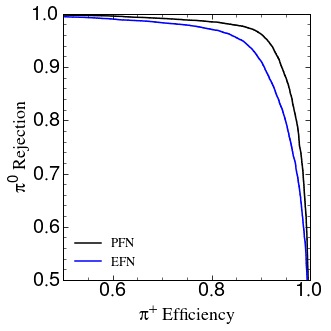

In [149]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

######################### ROC Curve Plot #########################


# plot the ROC curves
axes.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
axes.plot(efn_tp, 1-efn_fp, '-', color='blue', label='EFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(0.5, 1)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## EMProb

In [51]:
X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)

In [53]:
X = np.concatenate((X_pipm[:90000], X_pi0[:90000]))

In [152]:
tree_pipm.keys(filter_name="*cluster*")

['cluster_E',
 'cluster_E_LCCalib',
 'cluster_Pt',
 'cluster_Eta',
 'cluster_Phi',
 'cluster_nCells',
 'cluster_ENG_CALIB_TOT',
 'cluster_ENG_CALIB_OUT_T',
 'cluster_ENG_CALIB_DEAD_TOT',
 'cluster_EM_PROBABILITY',
 'cluster_HAD_WEIGHT',
 'cluster_OOC_WEIGHT',
 'cluster_DM_WEIGHT',
 'cluster_CENTER_MAG',
 'cluster_FIRST_ENG_DENS',
 'cluster_CENTER_LAMBDA',
 'cluster_ISOLATION',
 'cluster_ENERGY_DigiHSTruth',
 'cluster_cell_ID',
 'cluster_cell_E',
 'cluster_hitsTruthIndex',
 'cluster_hitsTruthE']

* loadVectorBranchFlat(branchName, tree): 

 converts to numpy a flatten array for the desired branch (no event index). But in this case is not padded

In [153]:
clus_EMProb_pipm = gu.loadVectorBranchFlat('cluster_EM_PROBABILITY', tree_pipm)

clus_EMProb_pi0 = gu.loadVectorBranchFlat('cluster_EM_PROBABILITY', tree_pi0)

In [158]:
print("number of pi0 clusters: ",len(clus_EMProb_pi0))

number of pi0 clusters:  421481


In [160]:
clus_EMProb_pipm_sel = clus_EMProb_pipm[selection_pipm]
clus_EMProb_pi0_sel = clus_EMProb_pi0[selection_pi0]

In [161]:
scores_EM_PROBABILITY = np.concatenate((clus_EMProb_pipm_sel[:90000],clus_EMProb_pi0_sel[:90000]))

In [166]:
len(scores_EM_PROBABILITY)
# len(X) == len(Y)

180000

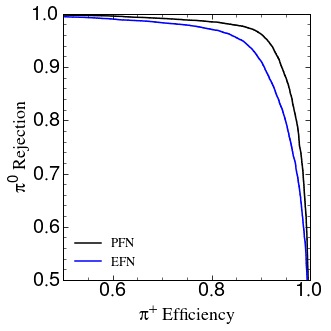

In [167]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

######################### ROC Curve Plot #########################


# plot the ROC curves
axes.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='PFN')
axes.plot(efn_tp, 1-efn_fp, '-', color='blue', label='EFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(0.5, 1)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## Playing

In [118]:
X[0]

array([[ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,
         2.00000000e-01],
       [ 1.74413206e+00,  4.29523364e-03, -2.63937712e-02,
         2.00000000e-01],
       [ 3.16158280e+00,  4.29426134e-03,  2.27617025e-02,
         2.00000000e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [121]:
X.shape

(180000, 2000, 4)

In [129]:
# The energy part
# [:,:,0] -> [firstrow:lastrow cluster,firstrow:lastrow cells,0 column]
X[:,:,0].shape

(180000, 2000)

In [130]:
#last Element of the energies
X[179999,1999,0]

0.0

In [132]:
# The angular part + sampling ID
# 1: -> From entry 1 on
X[:,:,1:]

array([[[ 4.29472327e-03, -1.81615353e-03,  2.00000000e-01],
        [ 4.29523364e-03, -2.63937712e-02,  2.00000000e-01],
        [ 4.29426134e-03,  2.27617025e-02,  2.00000000e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.01725679e-01, -1.66788459e-01,  1.20000000e+00],
        [ 1.01725679e-01, -2.64963150e-01,  1.20000000e+00],
        [ 1.01725679e-01, -6.86136484e-02,  1.20000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-5.15173003e-02,  1.66359782e-01,  1.20000000e+00],
        [-5.15173003e-02,  6.81849718e-02,  1.20000000e+00],
        [-5.15173003e-02,  2.64534593e-01,  1.20000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,